### Кейс 2 - определение ССЗ

Нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\Инна\AppData\Local\Temp\ipykernel_14772\1317150810.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию. Применяется Логистическая регрессия.

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# Найти индекс наибольшего значения f
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc_auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

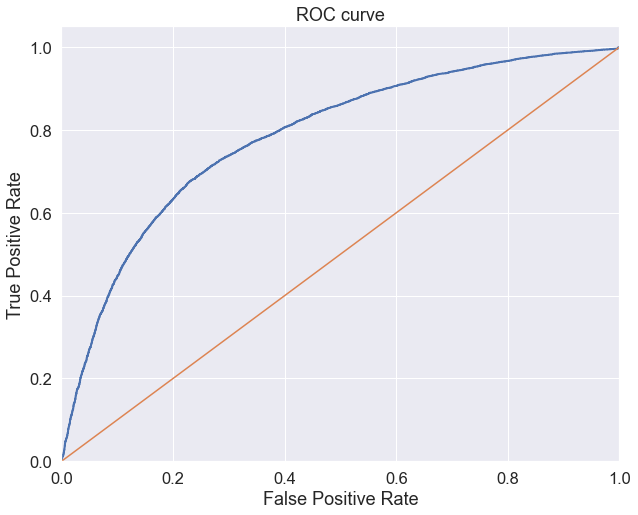

In [8]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score, log_loss

print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230664


Поcтроим на матрицу ошибок

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Эта функция печатает и строит матрицу ошибок.
     Нормализация может быть применена установкой `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


C:\Users\Инна\AppData\Local\Temp\ipykernel_14772\363945411.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


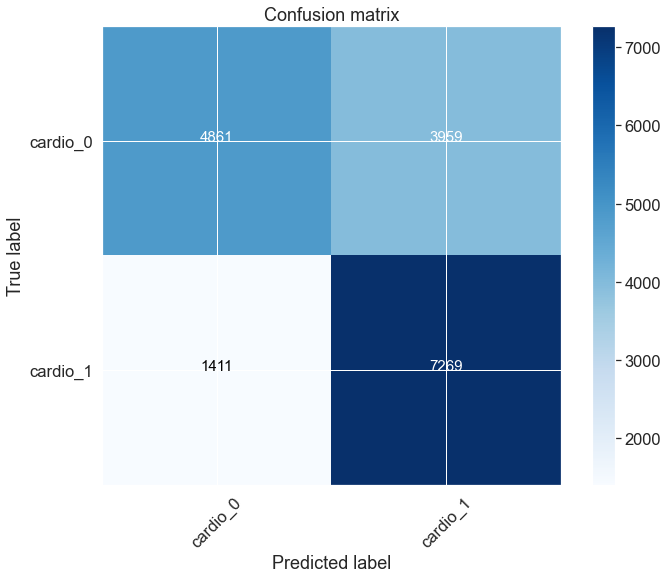

In [11]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [12]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

#### Пробуем модель Случайного Леса

In [13]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)



Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [14]:
pipeline.predict_proba(X_test)

array([[0.69, 0.31],
       [0.83, 0.17],
       [0.97, 0.03],
       ...,
       [0.95, 0.05],
       [0.18, 0.82],
       [0.27, 0.73]])

In [15]:
from sklearn.metrics import roc_auc_score, log_loss

print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:,1])))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


In [16]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.31, 0.17, 0.03, 0.14, 0.32, 0.48, 0.05, 0.82, 0.61, 0.98])

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')  

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


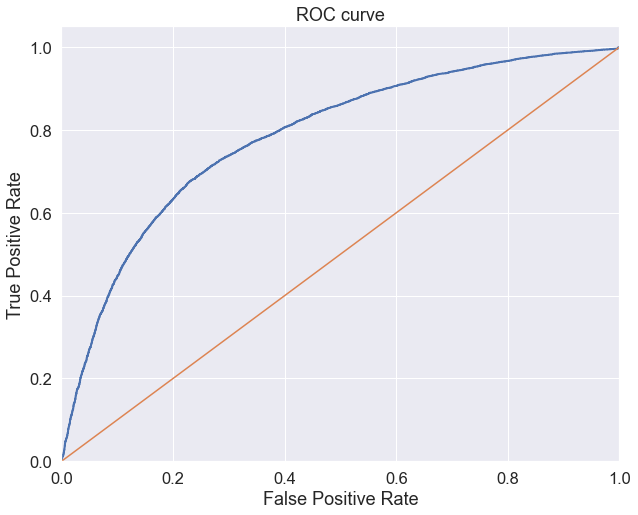

In [18]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Confusion matrix, without normalization
[[4088 4732]
 [1036 7644]]


C:\Users\Инна\AppData\Local\Temp\ipykernel_14772\363945411.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


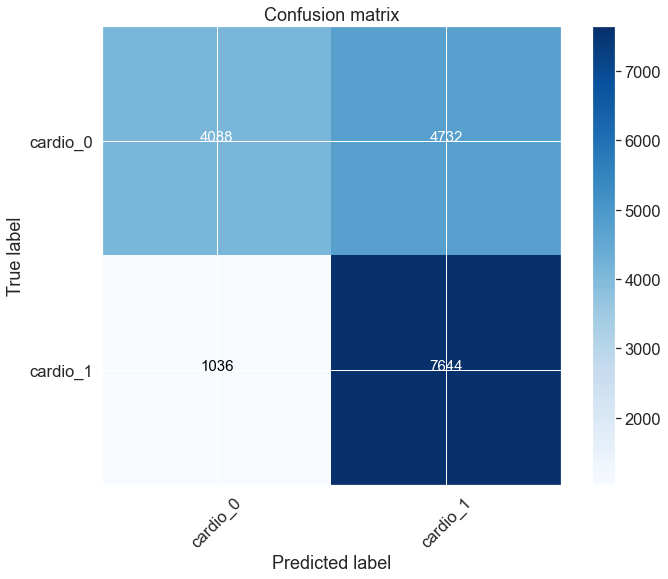

In [19]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [20]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8806451612903226, 0.5365079365079365, 0.4634920634920635)

In [21]:
#(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate стал еще выше ~ 0.54. True Positive увеличился почти на 5%.

Это означает, что 54 % всех пациентов получат метку 1 при том, что они на самом деле здоровы. Однако надо отметить, что благодаря небольшому снижению порога, F-мера и остальные метрики немного повышается, что в конечном счете привело к выявлению большего числа истинно больных пациентов: 7644 в RandomForest против 7269 в LogisticRegression, и уменьшеню FN- пациентов (которых не выявили вовремя, но они больны): 1036 в RandomForest против 1411 в LogisticRegression, а это в свою очередь значительно снизит фактические расходы на их лечение в целом по компании.

In [22]:
# RandomForest:Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816
# LogReg:Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838

#### Пробуем модель CatBoostClassifier

In [23]:
from catboost import CatBoostClassifier

In [24]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Learning rate set to 0.055904
0:	learn: 0.6767260	total: 144ms	remaining: 2m 23s
1:	learn: 0.6621953	total: 152ms	remaining: 1m 15s
2:	learn: 0.6491613	total: 160ms	remaining: 53.3s
3:	learn: 0.6382075	total: 169ms	remaining: 42.1s
4:	learn: 0.6282054	total: 177ms	remaining: 35.2s
5:	learn: 0.6191653	total: 187ms	remaining: 31s
6:	learn: 0.6110210	total: 199ms	remaining: 28.2s
7:	learn: 0.6041226	total: 209ms	remaining: 25.9s
8:	learn: 0.5977244	total: 219ms	remaining: 24.1s
9:	learn: 0.5923178	total: 228ms	remaining: 22.6s
10:	learn: 0.5877074	total: 235ms	remaining: 21.2s
11:	learn: 0.5834603	total: 243ms	remaining: 20s
12:	learn: 0.5797696	total: 250ms	remaining: 19s
13:	learn: 0.5761246	total: 258ms	remaining: 18.1s
14:	learn: 0.5730020	total: 266ms	remaining: 17.5s
15:	learn: 0.5702167	total: 275ms	remaining: 16.9s
16:	learn: 0.5676907	total: 284ms	remaining: 16.4s
17:	learn: 0.5654239	total: 291ms	remaining: 15.9s
18:	learn: 0.5632249	total: 299ms	remaining: 15.5s
19:	learn: 0.56

167:	learn: 0.5312798	total: 1.5s	remaining: 7.41s
168:	learn: 0.5312240	total: 1.5s	remaining: 7.4s
169:	learn: 0.5311724	total: 1.51s	remaining: 7.39s
170:	learn: 0.5311524	total: 1.52s	remaining: 7.37s
171:	learn: 0.5311011	total: 1.53s	remaining: 7.36s
172:	learn: 0.5310547	total: 1.53s	remaining: 7.34s
173:	learn: 0.5310128	total: 1.54s	remaining: 7.33s
174:	learn: 0.5309734	total: 1.55s	remaining: 7.32s
175:	learn: 0.5309583	total: 1.56s	remaining: 7.31s
176:	learn: 0.5309334	total: 1.57s	remaining: 7.29s
177:	learn: 0.5309093	total: 1.58s	remaining: 7.28s
178:	learn: 0.5308795	total: 1.58s	remaining: 7.26s
179:	learn: 0.5308441	total: 1.59s	remaining: 7.25s
180:	learn: 0.5308023	total: 1.6s	remaining: 7.24s
181:	learn: 0.5307475	total: 1.61s	remaining: 7.22s
182:	learn: 0.5306834	total: 1.61s	remaining: 7.21s
183:	learn: 0.5306670	total: 1.62s	remaining: 7.2s
184:	learn: 0.5305923	total: 1.63s	remaining: 7.18s
185:	learn: 0.5305778	total: 1.64s	remaining: 7.17s
186:	learn: 0.530

334:	learn: 0.5239701	total: 2.81s	remaining: 5.57s
335:	learn: 0.5239291	total: 2.82s	remaining: 5.57s
336:	learn: 0.5238881	total: 2.83s	remaining: 5.56s
337:	learn: 0.5238618	total: 2.83s	remaining: 5.55s
338:	learn: 0.5238136	total: 2.84s	remaining: 5.54s
339:	learn: 0.5237706	total: 2.85s	remaining: 5.53s
340:	learn: 0.5237315	total: 2.86s	remaining: 5.52s
341:	learn: 0.5236671	total: 2.87s	remaining: 5.51s
342:	learn: 0.5236235	total: 2.88s	remaining: 5.51s
343:	learn: 0.5235831	total: 2.88s	remaining: 5.5s
344:	learn: 0.5235248	total: 2.89s	remaining: 5.49s
345:	learn: 0.5234879	total: 2.9s	remaining: 5.48s
346:	learn: 0.5234306	total: 2.91s	remaining: 5.47s
347:	learn: 0.5233668	total: 2.92s	remaining: 5.46s
348:	learn: 0.5233379	total: 2.92s	remaining: 5.46s
349:	learn: 0.5233136	total: 2.93s	remaining: 5.45s
350:	learn: 0.5232731	total: 2.94s	remaining: 5.44s
351:	learn: 0.5232454	total: 2.95s	remaining: 5.43s
352:	learn: 0.5232279	total: 2.96s	remaining: 5.42s
353:	learn: 0.

504:	learn: 0.5179428	total: 4.1s	remaining: 4.02s
505:	learn: 0.5179188	total: 4.11s	remaining: 4.01s
506:	learn: 0.5178884	total: 4.12s	remaining: 4s
507:	learn: 0.5178551	total: 4.13s	remaining: 4s
508:	learn: 0.5178003	total: 4.13s	remaining: 3.99s
509:	learn: 0.5177629	total: 4.14s	remaining: 3.98s
510:	learn: 0.5177154	total: 4.15s	remaining: 3.97s
511:	learn: 0.5177116	total: 4.16s	remaining: 3.96s
512:	learn: 0.5176829	total: 4.17s	remaining: 3.96s
513:	learn: 0.5176480	total: 4.17s	remaining: 3.95s
514:	learn: 0.5176102	total: 4.18s	remaining: 3.94s
515:	learn: 0.5175604	total: 4.19s	remaining: 3.93s
516:	learn: 0.5175125	total: 4.2s	remaining: 3.92s
517:	learn: 0.5174686	total: 4.21s	remaining: 3.91s
518:	learn: 0.5174198	total: 4.21s	remaining: 3.9s
519:	learn: 0.5174044	total: 4.22s	remaining: 3.9s
520:	learn: 0.5173781	total: 4.23s	remaining: 3.89s
521:	learn: 0.5173353	total: 4.24s	remaining: 3.88s
522:	learn: 0.5173048	total: 4.25s	remaining: 3.87s
523:	learn: 0.5172666	

671:	learn: 0.5124640	total: 5.45s	remaining: 2.66s
672:	learn: 0.5124169	total: 5.46s	remaining: 2.65s
673:	learn: 0.5123680	total: 5.47s	remaining: 2.64s
674:	learn: 0.5123492	total: 5.47s	remaining: 2.63s
675:	learn: 0.5123250	total: 5.48s	remaining: 2.63s
676:	learn: 0.5122700	total: 5.49s	remaining: 2.62s
677:	learn: 0.5122386	total: 5.5s	remaining: 2.61s
678:	learn: 0.5122116	total: 5.5s	remaining: 2.6s
679:	learn: 0.5121917	total: 5.51s	remaining: 2.59s
680:	learn: 0.5121800	total: 5.52s	remaining: 2.58s
681:	learn: 0.5121596	total: 5.53s	remaining: 2.58s
682:	learn: 0.5121316	total: 5.54s	remaining: 2.57s
683:	learn: 0.5121159	total: 5.54s	remaining: 2.56s
684:	learn: 0.5120773	total: 5.55s	remaining: 2.55s
685:	learn: 0.5120544	total: 5.56s	remaining: 2.54s
686:	learn: 0.5120249	total: 5.56s	remaining: 2.54s
687:	learn: 0.5119958	total: 5.57s	remaining: 2.53s
688:	learn: 0.5119539	total: 5.58s	remaining: 2.52s
689:	learn: 0.5119271	total: 5.59s	remaining: 2.51s
690:	learn: 0.5

837:	learn: 0.5077303	total: 6.75s	remaining: 1.3s
838:	learn: 0.5076874	total: 6.75s	remaining: 1.3s
839:	learn: 0.5076577	total: 6.76s	remaining: 1.29s
840:	learn: 0.5076240	total: 6.77s	remaining: 1.28s
841:	learn: 0.5075711	total: 6.78s	remaining: 1.27s
842:	learn: 0.5075142	total: 6.79s	remaining: 1.26s
843:	learn: 0.5074535	total: 6.8s	remaining: 1.26s
844:	learn: 0.5074254	total: 6.8s	remaining: 1.25s
845:	learn: 0.5074233	total: 6.81s	remaining: 1.24s
846:	learn: 0.5073964	total: 6.82s	remaining: 1.23s
847:	learn: 0.5073548	total: 6.83s	remaining: 1.22s
848:	learn: 0.5073162	total: 6.83s	remaining: 1.22s
849:	learn: 0.5073154	total: 6.84s	remaining: 1.21s
850:	learn: 0.5072873	total: 6.85s	remaining: 1.2s
851:	learn: 0.5072536	total: 6.86s	remaining: 1.19s
852:	learn: 0.5072211	total: 6.87s	remaining: 1.18s
853:	learn: 0.5071706	total: 6.87s	remaining: 1.18s
854:	learn: 0.5071340	total: 6.88s	remaining: 1.17s
855:	learn: 0.5071207	total: 6.89s	remaining: 1.16s
856:	learn: 0.507

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [25]:
pipeline.predict_proba(X_test)

array([[0.8608224 , 0.1391776 ],
       [0.8060602 , 0.1939398 ],
       [0.63720859, 0.36279141],
       ...,
       [0.89907383, 0.10092617],
       [0.22651943, 0.77348057],
       [0.22527556, 0.77472444]])

In [26]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:,1])))

roc auc score: 0.8012110424046732
log loss score: 0.5414379890377439


In [27]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1391776 , 0.1939398 , 0.36279141, 0.12241737, 0.17896001,
       0.4392375 , 0.23442984, 0.85972258, 0.49403995, 0.94149165])

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')  

Best Threshold=0.3671633339776841, F-Score=0.740, Precision=0.677, Recall=0.814


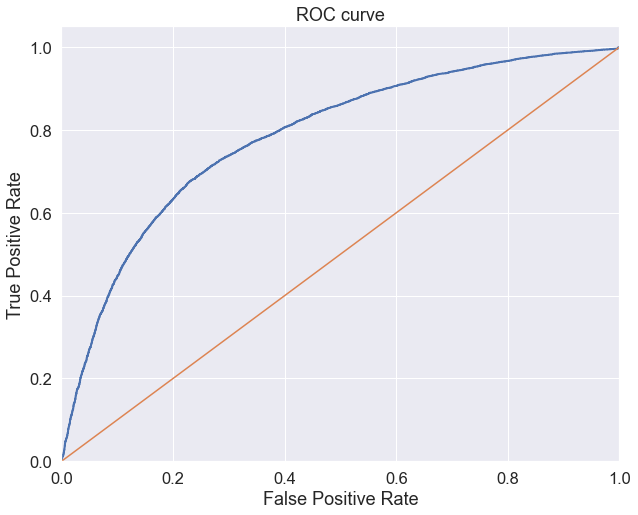

In [29]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Confusion matrix, without normalization
[[4409 4411]
 [1200 7480]]


C:\Users\Инна\AppData\Local\Temp\ipykernel_14772\363945411.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


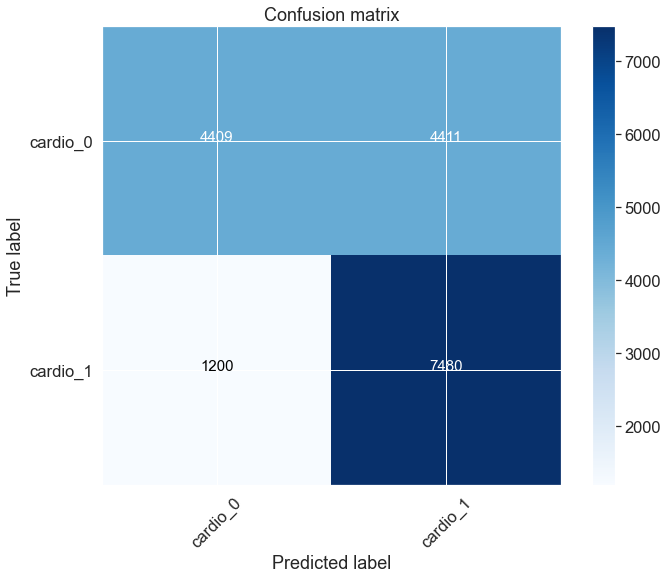

In [30]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [31]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8617511520737328, 0.5001133786848072, 0.49988662131519274)

In [32]:
# RandomForest:      Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816
# LogReg:            Best Threshold=0.386, F-Score=0.730, Precision=0.647, Recall=0.838
# CatBoostClassifier:Best Threshold=0.36, F-Score=0.740, Precision=0.677, Recall=0.814

In [33]:
#(0.837442396313364, 0.44886621315192743, 0.5511337868480726)
#(0.8806451612903226, 0.5365079365079365, 0.4634920634920635)
#(0.8617511520737328, 0.5001133786848072, 0.49988662131519274)

False Positive Rate ниже, чем в модели Случайного леса, но выше, чем в Логистической реграссии ~ 0.50. True Positive увеличился почти на 5%.

Это означает, что 50 % всех пациентов получат метку 1 при том, что они на самом деле здоровы. Однако надо отметить, что благодаря небольшому снижению порога, F-мера и остальные метрики немного повышается, что в конечном счете привело к выявлению большего числа истинно больных пациентов: 7480 в RandomForest против 7269 в LogisticRegression, и уменьшеню FN- пациентов (которых не выявили вовремя, но они больны): 1200  в RandomForest против 1411 в LogisticRegression, а это в свою очередь значительно снизит фактические расходы на их лечение в целом по компании.

Таким образом, можно предположить, что с математической точки зрения Линейная регрессия по по соотношению ошибок побеждает, а с экономической - побеждает модель Случайного леса. Однако если посмотреть на основные метрики, то более сбалансированной выглядит модель CatBoost со своими F-Score=0.740, Precision=0.677, Recall=0.814 и более усредненными показателями TP и FN. 